# Running Computational Alchemy for Catalysis: Binding Energy Predictions
This notebook outlines Python functions that use information from VASP calculations to predict descriptors for hypothetical catalyst. These functions utilize tools from the Atomic Simulation Environment (ASE) to manipulate catalyst surface models and perform calculations with computational alchemy. 

In this example, we apply computational alchemy on reference calculcations of OH binding on Pt(111) to predict binding energies (BEs) of OH on hypothetical alloys of Pt(111). 

Here we make ASE Atoms objects with VASP POSCARs and CONTCARs for the bare catalyst surface (`slab`) and the catalyst surface with an adsorbate (`ads`). These models and the results of the VASP calculations for each will be used as our reference for computational alchemy calculations.

In [1]:
import comp_alchemy

In [1]:
from ase.io import read 
from ase.visualize import view

slab = read('POSCAR-pt',format='vasp')
slab_contcar = read('CONTCAR-pt',format='vasp')

ads = read('POSCAR-pt-oh',format='vasp')
ads_contcar = read('CONTCAR-pt-oh',format='vasp')

To do computational alchemy, we label the atoms in our models using indexes assigned by ASE.

However, it's very likely that the atom indexes between slab and ads won't match. For instance, the atom located at the origin of the unit cell in slab may be indexed as 0, while the atom at the origin in ads may be indexed as 1. 

Here we use the `pairs` function to find the index of an atom in ads that share the same position in the unit cell with an atom in slab.

In [3]:
from comp_alchemy.ads_slab_pairs import pairs

p = pairs(slab,ads)

print(f'Ordering: [slab index, ads index]\n{p}')

Ordering: [slab index, ads index]
[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15]]


### Working with electrostatic potentials in VASP OUTCAR
Next we can grab the atom-centered electrostatic potentials (ESPs) printed at the end of the OUTCAR with `grab_esp()`. 
Here we grab ESPs for slab and ads and calculate the differences with `espdiff()`. The ESP differences define the alchemical potentials that facilitate predictions with alchemy.

In [4]:
from comp_alchemy.elec_stat_pot import (grab_esp,espdiff,remove_duplicate_espdiffs,heatmap)
import numpy as np

slab_elec = grab_esp(poscar='POSCAR-pt',outcar='OUTCAR-pt')
ads_elec = grab_esp(poscar='POSCAR-pt-oh',outcar='OUTCAR-pt-oh')

diffs = [e for e in espdiff(elec1=slab_elec,elec2=ads_elec,pair=p)]

In [6]:
print(f'''
Atom-centered electrostatic potentials:
Slab:
{slab_elec}

Ads:
{ads_elec}

Differences in electrostatic potentials between ads and slab
{np.round(diffs,4)}''')


Atom-centered electrostatic potentials:
Slab:
[-73.7028, -73.7028, -73.7028, -73.7028, -74.149, -74.149, -74.149, -74.149, -74.0946, -74.0946, -74.0946, -74.0946, -73.626, -73.626, -73.626, -73.626]

Ads:
[-73.3281, -73.3281, -73.3321, -73.2431, -73.8119, -73.7731, -73.7022, -73.7022, -73.7062, -73.7062, -73.8928, -73.6539, -73.7444, -73.7444, -73.2464, -73.2391, -76.4712, -39.6329]

Differences in electrostatic potentials between ads and slab
[ 0.3747  0.3747  0.3707  0.4597  0.3371  0.3759  0.4468  0.4468  0.3884
  0.3884  0.2018  0.4407 -0.1184 -0.1184  0.3796  0.3869]


### Visualizing alchemical derivatives
With the `heatmap()` function, visualize the alchemical derivatives with ASE GUI by running the cell below, pressing "c" in ASE GUI, and under "Choose how the atoms are colored:" selecting "By initial charge." You may need to uncomment `view(slab_vis)`. 

In [7]:
slab_vis = heatmap(poscar='POSCAR-pt',
                   dexlist=[dex[0] for dex in p],
                   espdiffs=diffs)
#view(slab_vis)

### Creating hypothetical materials by making transmutations
Below we use the `index_transmuted()` function to grab indexes of atoms that we want to transmute in our reference slabs. We specify the number of transmutable atoms by setting `transmute_num`. 

This function also grabs indexes of atoms at the bottom of the slab that we can counter-transmute to maintain isoelectronicity. We set the number of counter-transmutable atoms with `counter_num`.

In [8]:
from ase import Atom
from comp_alchemy.alloy_index import index_transmuted, transmuter, transmuted_directory_names

metal = Atom('Pt')

[transmute, counter] = index_transmuted(slab=slab,
                                        transmute_atom_sym=metal.symbol,
                                        counter_atom_sym=metal.symbol,
                                        transmute_num=8,
                                        counter_num=4,
                                        symmetric = False)

We can filter through the ESP differences centered at each transmutable atom with `remove_duplicate_espdiffs()`. This reduces the number of systems to study by recording unique alchemical derivatives, the minimum amount needed to thoroughly assess alchemy. This step is optional if you want to make all possible transmutations to your reference system and assess them all.

In this case, we will just filter ESP differences at the counter transmutations sites. 

In [9]:
counter = remove_duplicate_espdiffs(dexlist=counter,
                                        espdiffs=diffs)

Unique Electrostatic Potential Differences:
dict_values([0.37469999999999004, 0.37069999999999936, 0.459699999999998])

Unique Electrostatic Potential Differences WITHIN A TOLERANCE VALUE:
[0.37069999999999936, 0.459699999999998]
 


In [10]:
print(f'''Indices of atoms to be transmuted in the top two surface layers.
{transmute}

Indices of atoms to be counter transmuted with unique electrostatic potential differences.
{counter}

There are {len(transmute)} sites near the surface of the catalyst where we will make transmutations.

For each transmutation, we can make counter transmutations at 1 of {len(counter)} sites.

Considering all combinations of transmute and counter-transmute sites, we will assess a total of {len(transmute)*len(counter)} hypothetical configurations of alloys.
''')

Indices of atoms to be transmuted in the top two surface layers.
[12, 13, 14, 15, 8, 9, 10, 11]

Indices of atoms to be counter transmuted with unique electrostatic potential differences.
[2, 3]

There are 8 sites near the surface of the catalyst where we will make transmutations.

For each transmutation, we can make counter transmutations at 1 of 2 sites.

Considering all combinations of transmute and counter-transmute sites, we will assess a total of 16 hypothetical configurations of alloys.



In this example, we transmute surface Pt atoms to Au or Ir (change in nuclear charge of +/- 1) and counter-transmute Pt atoms in the bottom layers to Ir or Au (change in nuclear charge of -/+ 1). Below we construct an array with Au and Ir Atom objects to use in the `transmuter()` function.

In [11]:
charge = [1,-1]
chargelen = len(charge)

all_transmute = []

for c in charge:
    
    transmute_atom = Atom(metal.symbol)
    transmute_atom.number += c
    
    counter_transmute_atom = Atom(metal.symbol)
    counter_transmute_atom.number -= c
    
    all_transmute.append([counter_transmute_atom,transmute_atom])

Next, we make transmutations to Atoms objects of slab and ads from their respective CONTCARs and give labels for each new model with the `transmuted_directory_names()` function. Now we can visualize these new systems and write POSCARs to do VASP calculations for benchmarking.

In [12]:
print('Transmuted Slab Labels  Transmuted Ads Labels')

transmuted_slabs = []
dir_slab = []
transmuted_ads = []
dir_ads = []

for k in all_transmute:
    
    slab_dir_names = []
    t_slab = []
    ads_dir_names = []
    t_ads = []
    
    for i,c in enumerate(counter):
        
        ac = p[c][1]
        
        for j,t in enumerate(transmute):
            
            t_slab.append(transmuter(slab=slab_contcar,
                                           atomdex=[c,t],
                                           trans=k))
            slab_dname = transmuted_directory_names(bdex=i,
                                           tdex=j,
                                           dexes=[c,t],
                                           atoms_array=k)
            slab_dir_names.append(slab_dname)
        
            at = p[t][1]
            t_ads.append(transmuter(slab=ads_contcar,
                                         atomdex=[ac,at],
                                         trans=k))
            ads_dname = transmuted_directory_names(bdex=i,
                                           tdex=j,
                                           dexes=[ac,at],
                                           atoms_array=k)
            ads_dir_names.append(ads_dname) 
            print(slab_dname,'',ads_dname)
            
    transmuted_slabs.append(t_slab)
    transmuted_ads.append(t_ads)
    
    dir_slab.append(slab_dir_names)
    dir_ads.append(ads_dir_names)    

Transmuted Slab Labels  Transmuted Ads Labels
0.0.Ir2.Au12  0.0.Ir2.Au12
0.1.Ir2.Au13  0.1.Ir2.Au13
0.2.Ir2.Au14  0.2.Ir2.Au14
0.3.Ir2.Au15  0.3.Ir2.Au15
0.4.Ir2.Au8  0.4.Ir2.Au8
0.5.Ir2.Au9  0.5.Ir2.Au9
0.6.Ir2.Au10  0.6.Ir2.Au10
0.7.Ir2.Au11  0.7.Ir2.Au11
1.0.Ir3.Au12  1.0.Ir3.Au12
1.1.Ir3.Au13  1.1.Ir3.Au13
1.2.Ir3.Au14  1.2.Ir3.Au14
1.3.Ir3.Au15  1.3.Ir3.Au15
1.4.Ir3.Au8  1.4.Ir3.Au8
1.5.Ir3.Au9  1.5.Ir3.Au9
1.6.Ir3.Au10  1.6.Ir3.Au10
1.7.Ir3.Au11  1.7.Ir3.Au11
0.0.Au2.Ir12  0.0.Au2.Ir12
0.1.Au2.Ir13  0.1.Au2.Ir13
0.2.Au2.Ir14  0.2.Au2.Ir14
0.3.Au2.Ir15  0.3.Au2.Ir15
0.4.Au2.Ir8  0.4.Au2.Ir8
0.5.Au2.Ir9  0.5.Au2.Ir9
0.6.Au2.Ir10  0.6.Au2.Ir10
0.7.Au2.Ir11  0.7.Au2.Ir11
1.0.Au3.Ir12  1.0.Au3.Ir12
1.1.Au3.Ir13  1.1.Au3.Ir13
1.2.Au3.Ir14  1.2.Au3.Ir14
1.3.Au3.Ir15  1.3.Au3.Ir15
1.4.Au3.Ir8  1.4.Au3.Ir8
1.5.Au3.Ir9  1.5.Au3.Ir9
1.6.Au3.Ir10  1.6.Au3.Ir10
1.7.Au3.Ir11  1.7.Au3.Ir11


Images of a hyothetical alloy model bare and with the adsorbate below.

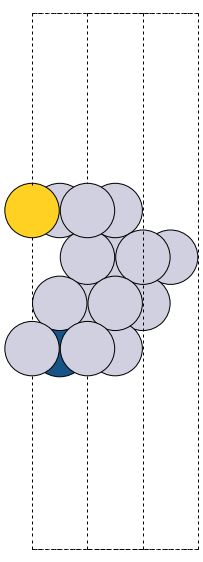

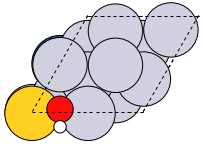

In [13]:
from IPython.display import Image
display(Image(filename=f'images/slab/{dir_slab[0][0]}.png'))
display(Image(filename=f'images/ads/{dir_ads[0][0]}.png'))

### Calculating binding energy (BE) with computational alchemy
For validation purposes, we could then setup and run VASP calculations for our transmuted surface models. It's most convinient to analyze these calculations if they are each stored in a directory named with the labels generated above. 
Once all VASP calculations are complete, we can calculate binding energies on our transmuted surfaces using alchemy, then compare against DFT-calculated binding energies.

First we calculate the binding energy of our reference system.

In [14]:
from comp_alchemy.read_oszicar import grab_energy

adsorbate_energy = -7.52462863#eV

slab_energy = grab_energy(oszicar='OSZICAR-pt')
ads_energy = grab_energy(oszicar='OSZICAR-pt-oh')

ref_be = slab_energy + adsorbate_energy - ads_energy

Next we grab energies of transmuted surfaces from VASP calculations and calculating binding energies for each. These energies were already parsed from the VASP output and stored in .csv files. We'll use `pandas.read_csv` to create a Dataframe with our VASP data. From there, we'll calculate $\Delta$BE.

In [29]:
import pandas as pd

transmuted_slab_data = pd.read_csv('slab_energies.csv',index_col='labels')
transmuted_slab_energies = [[transmuted_slab_data['energies'][lab] for lab in dir_slab[i]] for i in range(chargelen)]

transmuted_ads_data = pd.read_csv('ads_energies.csv',index_col='labels')
transmuted_ads_energies = [[transmuted_ads_data['energies'][lab] for lab in dir_ads[i]] for i in range(chargelen)]

transmuted_be = [[transmuted_slab_energies[i][j] + adsorbate_energy - transmuted_ads_energies[i][j] for j in range(len(transmuted_slab_energies[i]))] for i in range(chargelen)]
dft_del_be = [[transmuted_be[i][j] - ref_be for j in range(len(transmuted_be[i]))] for i in range(chargelen)]

Finally, we can use the `alc_be()` function to take the dot product of an array of charge differences and an array of the ESP differences to approximate $\Delta$BEs with computational alchemy. Below we've used this function to construct the charge difference array and calculate BE for every transmuted system. These arrays, which contain **all necessary information to predict BEs** are printed below the next two cells. 

In [18]:
from comp_alchemy.binding_energy import alc_be

dn = [[[alc_be(transmute=[transmute[i]],
             counter=[counter[j]],
             espdiffs=diffs,
             charge=charge[k])[0] for i in range(len(transmute))] for j in range(len(counter))] for k in range(chargelen)]

alc_del_be = [[[alc_be(transmute=[transmute[i]],
                     counter=[counter[j]],
                     espdiffs=diffs,
                     charge=charge[k])[1] for i in range(len(transmute))] for j in range(len(counter))] for k in range(chargelen)]

#Reducing list dimensions
dn = [[item for sublist in dn[i] for item in sublist] for i in range(chargelen)]
alc_del_be = [[item for sublist in alc_del_be[i] for item in sublist] for i in range(chargelen)]

In [20]:
print(f'''
Information used to calculate BEs with alchemy:

(1) Array of All Electrostatic Potential Differences:
{np.round(diffs,4)}

(2) Arrays of Charge Differences:
''')

for d in dn:
    for dd in d:
        print(dd)


Information used to calculate BEs with alchemy:

(1) Array of All Electrostatic Potential Differences:
[ 0.3747  0.3747  0.3707  0.4597  0.3371  0.3759  0.4468  0.4468  0.3884
  0.3884  0.2018  0.4407 -0.1184 -0.1184  0.3796  0.3869]

(2) Arrays of Charge Differences:

[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
[ 0

### Benchmarking computational alchemy against DFT

Now that the BEs are calculated, we can evaluate the accuracy of computational alchemy against DFT. For each BE, we calculate the absolute error between alchemy and DFT. These quantities are summarized at the end of this notebook.

In [22]:
ae = [[abs(alc_del_be[i][j] - dft_del_be[i][j]) for j in range(len(alc_del_be[i]))] for i in range(chargelen)]
mae = np.round(np.average(ae),3)

Below we also calcuate the distance between each transmute site and the binding site of OH. This quantity will help us analyze the data at the end of the notebook.

In [23]:
adsorbate_site = 'O'

adsorbate_indexes = [a.index for a in ads_contcar if a.symbol == adsorbate_site]

adsorbate_positions = [[ads_contcar[d].position[0],ads_contcar[d].position[1],ads_contcar[d].position[2]]for d in adsorbate_indexes]
adsorbate_positions = [items for item in adsorbate_positions for items in item if item[2] == max([pos[2] for pos in adsorbate_positions])]

distances = [[np.sqrt((ads_contcar[t].position[0]-adsorbate_positions[0])**2+(ads_contcar[t].position[1]-adsorbate_positions[1])**2+(ads_contcar[t].position[2]-adsorbate_positions[2])**2) for t in transmute*len(counter)] for i in range(chargelen)]

Here we construct a parity plot with Bokeh visualization tools. Select any of the tools from the side toolbar to interpret this figure anyway you prefer. You can click labels in the legend to hide/show groups of data, and you can hover your mouse over any data point to view detailed information that includes images of the hypothetical alloy, alchemy and DFT BEs, and absolute errors.

In [26]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, CustomJS, Range1d
from bokeh.models.annotations import Slope

output_notebook()

#HTML string for interactive bokeh figure
tooltips="""
            <p>
                <span style="font-size: 25px;">Surface Index:</span>
                <span style="font-size: 25px;">$index</span>
            </p>
            <p>
                <img
                src="@slab_imgs" height="100" alt="@slab_imgs" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
                ></img>
                <img
                src="@ads_imgs" height="150" alt="@ads_imgs" width="150"
                style="float: center; margin: 0px 15px 15px 0px;"
                border="2"
                ></img>
            </p>
            <p>
                <span style="font-size: 25px;">Label:</span>
                <span style="font-size: 25px; font-weight: bold;">@desc</span>
            </p>
            <p>
                <span style="font-size: 25px;">DFT, Alchemy:</span>
                <span style="font-size: 25px; font-weight: bold;">@x eV, @y eV</span>
            </p>
            <p>
                <span style="font-size: 25px;">Absolute Error:</span>
                <span style="font-size: 25px; font-weight: bold;">@aerr eV</span>
            </p>
"""

Loading BokehJS ...

In [27]:
pf = figure(plot_width=800, plot_height=800,tooltips=tooltips,title="Parity Plot for BE Predictions with Computational Alchemy")

parity = Slope(gradient=1,y_intercept=0,)
pf.add_layout(parity)

colors = ['blue','green','red','yellow','magenta','cyan','indigo']
mx = []
mn =[]
for i in range(chargelen):
    mx.append(max(dft_del_be[i]+alc_del_be[i]))
    mn.append(min(dft_del_be[i]+alc_del_be[i]))
    source = ColumnDataSource(data=dict(
            x=[d for d in dft_del_be[i]],
            y=[a for a in alc_del_be[i]],
            desc=dir_slab[i],
            ads_imgs=['images/ads/'+a+'.png' for a in dir_ads[i]],
            slab_imgs=['images/slab/'+s+'.png' for s in dir_slab[i]],
            aerr=ae[i],
            rad=[d/100 for d in distances[i]],
            color=[colors[i]]*len(alc_del_be[i])))
    pf.circle('x', 'y', radius='rad', fill_color ='color',source=source, line_color="black", line_width=2, fill_alpha=0.5, legend='delZ = '+str(charge[i]))


pf.asterisk(ref_be - ref_be,ref_be - ref_be,size=50,line_width=5,color='red',legend='BE_ref')

pf.xaxis.axis_label = "DFT"
pf.xaxis.axis_label_text_font_style = "bold"
pf.xaxis.axis_label_text_font_size = "20pt"
pf.xaxis.major_label_text_font_size = "20pt"
pf.xaxis.major_label_text_font_style = "bold"
pf.xaxis.major_tick_line_width = 2

pf.yaxis.axis_label = "Alchemy"
pf.yaxis.axis_label_text_font_style = "bold"
pf.yaxis.axis_label_text_font_size = "20pt"
pf.yaxis.major_label_text_font_size = "20pt"
pf.yaxis.major_label_text_font_style = "bold"
pf.yaxis.major_tick_line_width = 2


pf.title.text_font_size = '20pt'
pf.title.align = 'center'

pf.x_range=Range1d(-0.65,0.65)
pf.y_range=Range1d(-0.65,0.65)

pf.legend.location = "top_left"
pf.legend.click_policy = "hide"
pf.legend.label_text_font_size = "20pt"
pf.legend.glyph_height = 65
pf.legend.glyph_width = 65

show(pf)

The radii of the data points above correspond to distances from the binding site. The smaller the point, the closer the transmutation was made to the binding site. 

Below is a summary of pertinent quantities for this analysis. We can read through the list of absolute errors printed below and identify systems with inaccurate BE predictions. For these systems with low accuracy, we can look at the magnitude of the ESP difference and the transmutation index (location of transmuted atom). Low accuracy is typically attributed to systems where transmutations are made to atoms where the magnitude of the ESP difference is large. Above we can see that every data point that's away from the parity line belongs to a system where the transmutation was made at the binding site.

In [28]:
datsum = pd.DataFrame(columns=['labels','DFT Binding Energy','Alchemy Binding Energy',
                               'Absolute Errors','Transmutation Site Index',
                              'ESP Difference at Transmute Site'])
for i in range(chargelen):
    for j in range(len(dir_slab[i])):
        datsum = datsum.append({'labels': dir_slab[i][j], 
                                'DFT Binding Energy': dft_del_be[i][j], 
                                'Alchemy Binding Energy': alc_del_be[i][j],
                                'Absolute Errors': ae[i][j],
                                'Transmutation Site Index': (transmute*len(counter))[j],
                                'ESP Difference at Transmute Site': ([diffs[k] for k in transmute]*len(counter))[j]}, ignore_index=True)
print(datsum)

          labels  DFT Binding Energy  Alchemy Binding Energy  Absolute Errors  \
0   0.0.Ir2.Au12           -0.391207                 -0.4891         0.097893   
1   0.1.Ir2.Au13           -0.391218                 -0.4891         0.097882   
2   0.2.Ir2.Au14            0.097448                  0.0089         0.088548   
3   0.3.Ir2.Au15            0.057842                  0.0162         0.041642   
4    0.4.Ir2.Au8            0.014232                  0.0177         0.003468   
5    0.5.Ir2.Au9            0.014223                  0.0177         0.003477   
6   0.6.Ir2.Au10           -0.217217                 -0.1689         0.048317   
7   0.7.Ir2.Au11            0.067601                  0.0700         0.002399   
8   1.0.Ir3.Au12           -0.470229                 -0.5781         0.107871   
9   1.1.Ir3.Au13           -0.470238                 -0.5781         0.107862   
10  1.2.Ir3.Au14            0.006512                 -0.0801         0.086612   
11  1.3.Ir3.Au15           -